# Travelling Saleman Problem -- A Genetic Algorithmic Approach

In [31]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

In [32]:
class CitiesMap:
    """Euclidean map of random city locations."""
    def __init__(self, *, seed: int, num_cities: int, map_size: tuple[int, int]):
        self.seed = seed
        self.num_cities = num_cities
        self.map_size = map_size

        random.seed(self.seed)
        self.cities = [(random.random() * map_size[0], random.random() * map_size[1]) for i in range(num_cities)]

    def __str__(self) -> str:
        return ''.join([f'{city}' for city in self.cities])

    def __getitem__(self, index) -> tuple[float, float]:
        return self.cities[index]

    def __len__(self) -> int:
        return len(self.cities)

    def inter_dist(self, a: int, b: int) -> float:
        """Inter-distance between two cities by index."""
        return math.sqrt((self.cities[a][0] - self.cities[b][0])**2 
                         + (self.cities[a][1] - self.cities[b][1])**2)
        
    def get_flat_obs(self):
        """Flattens coordinates for NN input."""
        # Returns [x1, y1, x2, y2, ...]
        return np.array([coord for city in self.cities for coord in city])

    def plot(self) -> PathCollection:
        """Return plot of cities"""
        plt.scatter([x for x, y in self.cities], [y for x, y in self.cities])
        plt.xlim([0, self.map_size[0]])
        plt.ylim([0, self.map_size[1]])
        return plt

In [33]:
def loop(lst) -> []:
    """Return a looped list of paths to travel."""
    loop_lst = []
    for i, j in zip(lst, lst[1:]):
        loop_lst.append((i, j))
    loop_lst.append((lst[-1], lst[0]))
    return loop_lst

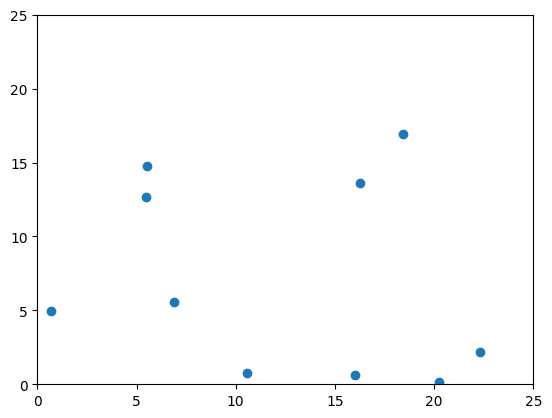

In [34]:
cm = CitiesMap(seed=42, num_cities=10, map_size=(25, 25))
cm.plot().show()

In [35]:
class TSM:
    """Taveling Salesman Agent."""
    def __init__(self, cities_map: CitiesMap):
        self.map = cities_map
        self.DNA = [i for i in range(self.map.num_cities)]
        random.shuffle(self.DNA)

    def dist(self) -> float:
        """Return total distance traveled."""
        return sum([self.map.inter_dist(i, j) for i, j in loop(self.DNA)])
    
    def plot(self) -> PathCollection:
        """Return plot of path traveled."""
        p = self.map.plot()
        for i, j in loop(self.DNA):
            ax, ay = self.map[i]
            bx, by = self.map[j]
            p.plot([ax, bx], [ay, by])

    def mutate(self, mutation_rate=0.02) -> None:
        if random.random() <= mutation_rate:
            samples = random.sample(range(len(self.map)), 2)
            self.DNA[samples[0]], self.DNA[samples[1]] = self.DNA[samples[1]], self.DNA[samples[0]]

    def cross_breed(self, other) -> 'TSM':
        ...

In [36]:
tsm = TSM(cm)

In [37]:
tsm.DNA

[4, 3, 0, 8, 7, 1, 9, 5, 6, 2]

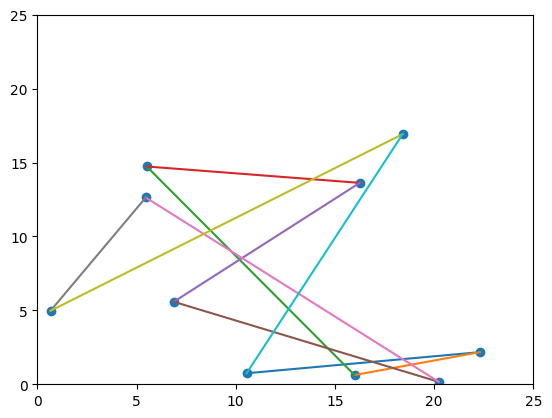

In [38]:
tsm.plot()

In [39]:
tsm.dist()

141.2303543090889

## GA Model

In [40]:
def calculate_total_distance(tour_indices, city_map):
    """Calculates distance of a specific path[cite: 74]."""
    dist = 0
    # Loop through path (0->1, 1->2...)
    for i in range(len(tour_indices)):
        a = tour_indices[i]
        b = tour_indices[(i + 1) % len(tour_indices)] # Wrap around to start
        dist += city_map.inter_dist(a, b)
    return dist

Starting Training for 15 generations...
Gen 0: Best Distance = 76.61
Gen 10: Best Distance = 68.87
Best Route Distance: 66.04
Training Complete.
Final Best Path: [3, 9, 0, 4, 1, 6, 5, 8, 7, 2]


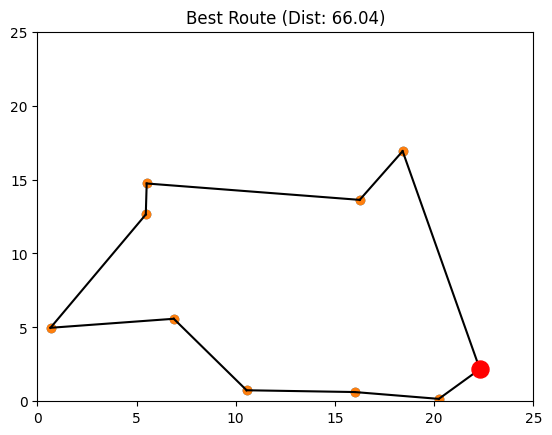

In [91]:
from ga_models.simple_genetic_algorithm import SimpleModel;

# 1. Setup Environment
random.seed(42)    # Locks python random (Mutation/Crossover)
np.random.seed(42) # Locks numpy random (Neural Network Weights)

NUM_CITIES = 10
MAP_SIZE = (25, 25)
cm = CitiesMap(seed=42, num_cities=NUM_CITIES, map_size=MAP_SIZE)
observation = cm.get_flat_obs() # Input vector size: 20 (10 cities * 2 coords)

# 2. Setup Population
POP_SIZE = 350
# Input: x,y for each city. Output: Score for each city. Hidden layer: 30 neurons.
dims = (NUM_CITIES * 2, 30, NUM_CITIES)
population = [SimpleModel(dims=dims) for _ in range(POP_SIZE)]

# 3. Evolution Loop
GENERATIONS = 15

print(f"Starting Training for {GENERATIONS} generations...")
for gen in range(GENERATIONS):
    # Evaluate everyone
    pop_scores = []
    for agent in population:
        tour = agent.get_tour(observation)
        dist = calculate_total_distance(tour, cm)
        pop_scores.append((dist, agent))
    
    # Sort by distance (lowest is best)
    pop_scores.sort(key=lambda x: x[0])
    
    best_dist, best_agent = pop_scores[0]
    
    if gen % 10 == 0:
        print(f"Gen {gen}: Best Distance = {best_dist:.2f}")
    
    # Selection (Keep top 50%)
    survivors = [agent for score, agent in pop_scores[:POP_SIZE//2]]
    
    # Repopulate
    new_population = []
    while len(new_population) < POP_SIZE:
        # Pick 2 parents randomly from survivors
        p1, p2 = random.sample(survivors, 2)
        child = p1 + p2 # Crossover
        child.mutate(0.1)
        new_population.append(child)
        
    population = new_population

print(f"Best Route Distance: {best_dist:.2f}")
print("Training Complete.")

final_tour = best_agent.get_tour(observation)
print(f"Final Best Path: {final_tour}")

# Simple Plotting Logic
plt.figure()
cm.plot()
# Plot the lines
for i in range(len(final_tour)):
    start_city = cm[final_tour[i]]
    end_city = cm[final_tour[(i+1)%len(final_tour)]]
    plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], 'k-')
cm.plot()
# 3. Highlight the FIRST city in Red (zorder=3 puts it on top)
start_idx = final_tour[0]
start_x, start_y = cm[start_idx]
plt.scatter([start_x], [start_y], c='red', s=150, label='Start City', zorder=3)
plt.title(f"Best Route (Dist: {best_dist:.2f})")
plt.show()
